In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from Models import BinaryClassifier
from Losses import BCELoss
from Optimizers import SGD, clip_grad_norm
from Scheduler import StepLR

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.datasets import make_circles, make_classification, make_moons

from tqdm import tqdm
from matplotlib import pyplot as plt

from Utils import binary_acc, moving_average, AverageMeter

Layers: 
1: ll1: Linear with parameters: W of shape [2 3] and b of shape [1 3] 
2: nl1: ReLu 
3: ll4: Linear with parameters: W of shape [3 1] and b of shape [1 1] 
4: nl4: Sigmoid 

Epoch-0: Average Training Loss   = 0.6731371997115491 and Accuracy   = 51.07204055786133.
Epoch-0: Average Evaluation Loss = 0.6330551497965494 and Accuracy = 63.0.
Current LR= 0.5
Epoch-9: Average Training Loss   = 0.06289830449429293 and Accuracy   = 98.25885009765625.
Epoch-9: Average Evaluation Loss = 0.05538526732414952 and Accuracy = 99.0.
Current LR= 0.5
Epoch-19: Average Training Loss   = 0.046812433979440425 and Accuracy   = 98.47374725341797.
Epoch-19: Average Evaluation Loss = 0.043132361692228664 and Accuracy = 99.0.
Current LR= 0.5
Epoch-29: Average Training Loss   = 0.042122077321549385 and Accuracy   = 98.8925552368164.
Epoch-29: Average Evaluation Loss = 0.03282082529810837 and Accuracy = 99.0.
Current LR= 0.5
Epoch-39: Average Training Loss   = 0.04050454299667968 and Accuracy   = 98.77899

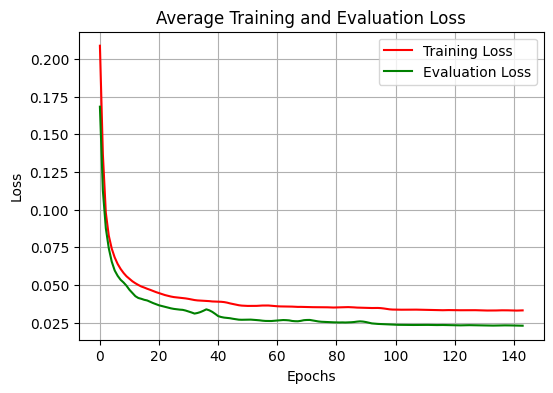

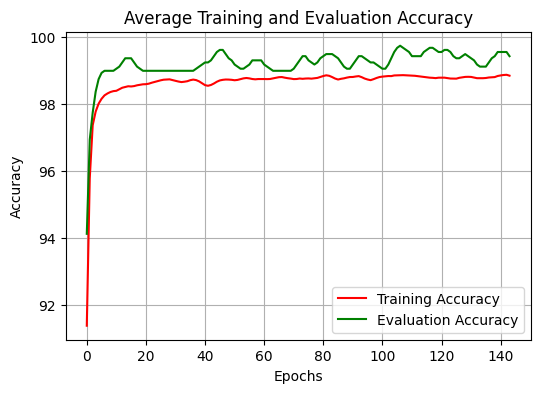

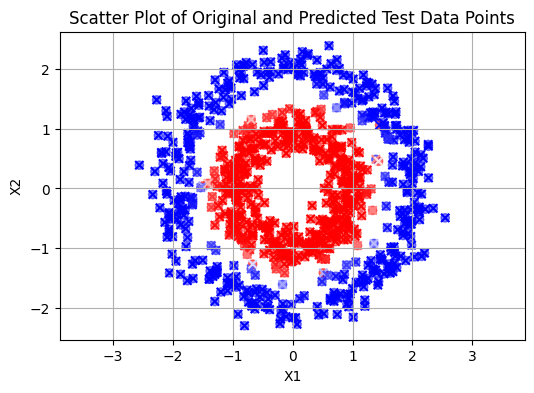

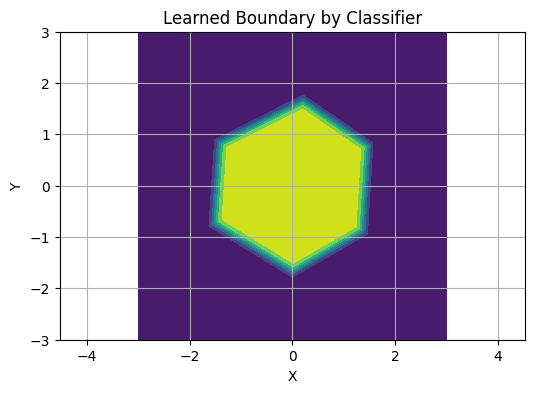

In [2]:
# Training Hyperparameters
max_epochs  = 150
batch_size  = 200
base_lr     = 0.5  # Intial Learning-Rate
clip_grad   = True  # If to clip calculated gradient before updating the parameters
max_norm    = 0.1   # Threshold to clip gradients
change_lr   = True  # If schedule to decay Learning-Rate with epochs
step_size   = 50     # Step-size to decay Learning-Rate
gamma       = 0.5   # Multiplier to decay Learning-Rate

# set seed for random generator
np.random.seed(123)
torch.manual_seed(123)

#========================= Create Synthetic Regression Data =========================#
N = 1024*4
#X, y = make_moons(n_samples=N, noise=0.1, random_state=42)
X, y = make_circles(n_samples=N, noise=0.1, factor=0.5, random_state=42)
X = X * 2
y = np.expand_dims(y, axis=1)
# Randomly Split data into training, and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=40)


#============= Instantiate model, loss, optimizer, and Learning-rate scheduler ===========#
model = BinaryClassifier(2, 1);   # Model
print(model)

# # Load Learned Model Parameters
# model.load_params('Learned_Models/BinaryClassifier.pkl')

loss_func = BCELoss() # Loss Function

optimizer = SGD(model, lr=base_lr, momentum=0.9, nesterov=True) # Instantiate Optimizer

if change_lr:
    # Learning-rate scheduler
    lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma, verbose=False)

#=============================== Create Dataset and DataLoader =============================#
train_dataset = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y)) # Create a dataset from training tensors
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # DataLoader for mini-batch training

#====================================== Start Training ===================================#

# Lists to store training and evaluation metrics history
train_loss_history = []
train_acc_history = []
eval_loss_history = []
eval_acc_history = []

# Main Training Loop
for epoch in range(max_epochs):
    train_epoch_loss = AverageMeter()
    train_epoch_acc = AverageMeter()
    eval_epoch_loss = AverageMeter()
    eval_epoch_acc = AverageMeter()

    #================================= Training Phase ============================#
    for batch_X, batch_y in train_dataloader: # Iterate over mini-batches
        batch_y = batch_y.detach().numpy()#.squeeze(axis=1)
        batch_X = batch_X.detach().numpy()#.squeeze(axis=1)

        # Calculate predicted value, i.e. Forward-pass
        pred_y = model.forward(batch_X)

        # Calcualte Loss
        train_loss = loss_func.forward(pred_y, batch_y)
        train_epoch_loss.update(train_loss, len(pred_y))
        

        # Calculate Accuracy
        train_acc = binary_acc(pred_y, batch_y)
        train_epoch_acc.update(train_acc, len(pred_y))

        # zero-out the gradients w.r.t the parameters
        model.zero_grad()

        # Calculate gradient of loss w.r.t pred_Y
        dL = loss_func.backward()

        # Calculate gradient of Loss w.r.t parameters
        model.backward(dL)

        if clip_grad:
            total_grad_norm = clip_grad_norm(model, max_norm=max_norm, norm_type= 2.0, error_if_nonfinite=True)
            # print("Total Grad Norm=", total_grad_norm)

        # Update model parameters
        optimizer.step()

    # Store the average loss and accuracy values for plotting
    train_loss_history.append(train_epoch_loss.avg)
    train_acc_history.append(train_epoch_acc.avg)

    if (epoch+1) % 10 == 0 or epoch==0:
        print("Epoch-{}: Average Training Loss   = {} and Accuracy   = {}.".format(epoch, train_epoch_loss.avg, train_epoch_acc.avg))

    #============================== Evaluation Phase =====================#

    # Calculate predicted value, i.e. Forward-pass
    pred_y = model.forward(test_X)

    # Calcualte Loss
    eval_loss = loss_func.forward(pred_y, test_y)
    eval_epoch_loss.update(eval_loss, len(pred_y))
    eval_loss_history.append(eval_loss)

    # Calculate Accuracy
    eval_acc = binary_acc(pred_y, test_y)
    eval_epoch_acc.update(eval_acc, len(pred_y))
    eval_acc_history.append(eval_acc)

    if (epoch+1) % 10 == 0 or epoch==0:
        print("Epoch-{}: Average Evaluation Loss = {} and Accuracy = {}.".format(epoch, eval_epoch_loss.avg, eval_epoch_acc.avg))
        print("Current LR=", lr_scheduler.get_last_lr())

    # Change learning-rate
    if change_lr:
        lr_scheduler.step()

# save the learned model parameters
# model.save_params('Learned_Models/BinaryClassifier.pkl')
print("Training Done!")

#========================= Plot Loss and Accuracy w.r.t Epochs =============================#
avg_window = np.array([1,2,3,4,3,2,1], dtype='float32')
plt.figure(figsize=(6,4))
avg_train_loss_history = moving_average(train_loss_history,avg_window)
avg_eval_loss_history = moving_average(eval_loss_history, avg_window)
plt.plot(range(len(avg_train_loss_history)), avg_train_loss_history, 'r')
plt.plot(range(len(avg_eval_loss_history)), avg_eval_loss_history, 'g')
plt.grid('on')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Average Training and Evaluation Loss")
plt.legend(['Training Loss', 'Evaluation Loss'])

plt.figure(figsize=(6,4))
avg_train_acc_history = moving_average(train_acc_history,avg_window)
avg_eval_acc_history = moving_average(eval_acc_history, avg_window)
plt.plot(range(len(avg_train_acc_history)), avg_train_acc_history, 'r')
plt.plot(range(len(avg_eval_acc_history)), avg_eval_acc_history, 'g')
plt.grid('on')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title("Average Training and Evaluation Accuracy")
plt.legend(['Training Accuracy', 'Evaluation Accuracy'])

# Plot the Original and Predicted Test Data points
plt.figure(figsize=(6,4))
y_pred = model.forward(test_X)
plt.scatter(test_X[:,0], test_X[:,1], c=test_y.reshape(-1), cmap='bwr', alpha=0.5)
plt.scatter(test_X[:,0], test_X[:,1], c=y_pred.reshape(-1), cmap='bwr', marker='x')
plt.grid('on')
plt.axis('equal')
plt.xlabel('X1'); plt.ylabel('X2')
plt.title("Scatter Plot of Original and Predicted Test Data Points")


#========================= Plot Learned Decision Boundary =============================#
# Generate a mesh-grid over region [-5, -5] x [-5, 5]

nx, ny = (2000, 2000)
x = np.linspace(-3, 3, nx)
y = np.linspace(-3, 3, ny)
xv, yv = np.meshgrid(x,y)
inputs = np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
outputs = model.forward(inputs)
#outputs = (outputs >= 0.5).astype(np.float32)
outputs = outputs.reshape(xv.shape)
plt.figure(figsize=(6,4))
plt.contourf(xv, yv, outputs)
plt.grid('on')
plt.axis('equal')
plt.xlabel('X'); plt.ylabel('Y')
plt.title("Learned Boundary by Classifier")
plt.show()
